In [30]:
import pandas as pd
import numpy as np
import time as time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error
%matplotlib inline

In [31]:
# import the data from the EDA notebook
df_iq = pd.read_csv('data/df_iq.csv', parse_dates=[1])
df_sj = pd.read_csv('data/df_sj.csv', parse_dates=[1])

In [32]:
df_iq.head()

,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,26,2000-07-01,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,298.450000,295.184286,...,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0,0
1,27,2000-07-08,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,298.428571,295.358571,...,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6,0
2,28,2000-07-15,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,297.392857,295.622857,...,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1,0
3,29,2000-07-22,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,296.228571,292.797143,...,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0,0
4,30,2000-07-29,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,297.635714,293.957143,...,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0,0


In [33]:
# check the range of timestamps
print('iq start date:',df_iq.week_start_date.min())
print('iq end date:',df_iq.week_start_date.max())
print('sj start date:',df_sj.week_start_date.min())
print('sj end date:',df_sj.week_start_date.max())

iq start date: 2000-07-01 00:00:00
iq end date: 2010-06-25 00:00:00
sj start date: 1990-04-30 00:00:00
sj end date: 2008-04-22 00:00:00


### Feature Engineering

In [34]:
# create mean ndvi
df_sj['ndvi_mean'] = (df_sj['ndvi_ne'] + df_sj['ndvi_nw'] + df_sj['ndvi_se'] + df_sj['ndvi_sw']) / 4.0
df_iq['ndvi_mean'] = (df_iq['ndvi_ne'] + df_iq['ndvi_nw'] + df_iq['ndvi_se'] + df_iq['ndvi_sw']) / 4.0

### Train - Vallidation Split

In [35]:
# scale the data and create features as discussed in the EDA notebook.
ss = StandardScaler()
Xs = ss.fit_transform(df_sj[df_sj.columns[2:24]])
df_sj_s = pd.DataFrame(Xs, columns = df_sj.columns[2:24], index=df_sj.index)
df_sj_s['week_start_date'] = df_sj['week_start_date']
df_sj_s['weekofyear'] = df_sj['weekofyear']
df_sj_s['month'] = df_sj_s.week_start_date.dt.month
df_sj_s['year'] = df_sj_s.week_start_date.dt.year
sj_train = df_sj_s[df_sj_s.week_start_date.dt.year <= 2002].drop('total_cases', axis=1)
sj_train_target = df_sj[df_sj.week_start_date.dt.year <= 2002].total_cases

sj_valid = df_sj_s[df_sj_s.week_start_date.dt.year > 2002].drop('total_cases', axis=1)
sj_valid_target = df_sj[df_sj.week_start_date.dt.year > 2002].total_cases

sj_train.drop('week_start_date', axis=1, inplace=True)
sj_valid.drop('week_start_date', axis=1, inplace=True)

print('Total:', df_sj.shape)
print('Train:', sj_train.shape)
print('Valid:', sj_valid.shape)
print(sj_train.shape[0] + sj_valid.shape[0])

Total: (936, 24)
Train: (659, 24)
Valid: (277, 24)
936


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [36]:
sj_train.head()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,...,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,ndvi_mean,weekofyear,month,year
0,0.618730,0.406732,0.386803,0.207545,-0.513013,-1.282015,-1.253898,-1.714497,-1.265623,-1.079864,...,0.228762,-1.100409,0.173508,-1.278687,-1.723054,-0.367775,0.600281,18,4,1990
1,1.069847,0.827328,-0.240873,-0.189115,-0.279993,-0.765638,-0.679726,-0.734948,-0.391773,-0.693609,...,-0.287676,-0.201443,-0.459811,0.059942,-0.261722,-0.620780,0.721719,19,5,1990
2,-0.242970,1.164151,-0.330476,0.086137,-0.017398,-0.304710,-0.322333,0.210006,-0.709537,0.001651,...,-0.431131,-0.201443,-0.322877,0.350949,0.136822,0.500648,0.294770,20,5,1990
3,0.676272,1.952837,0.891947,1.251919,-0.447140,-0.138360,-0.035247,0.130805,0.005432,-0.230103,...,-0.172912,0.333897,0.019457,0.991163,0.468943,-0.778054,1.637054,21,5,1990
4,1.320680,2.140254,1.302732,1.457218,-0.622801,0.291378,0.322146,0.456714,0.402637,0.156153,...,1.003419,1.374273,3.134700,1.980584,0.867488,-0.716512,2.166210,22,5,1990


In [37]:
# scale the data and create features as discussed in the EDA notebook.
ss = StandardScaler()
Xs = ss.fit_transform(df_sj[df_sj.columns[2:23]])
df_iq_s = pd.DataFrame(Xs, columns = df_iq.columns[2:23], index=df_sj.index)
df_iq_s['week_start_date'] = df_iq['week_start_date']
df_iq_s['weekofyear'] = df_iq['weekofyear']
df_iq_s['month'] = df_iq_s.week_start_date.dt.month
df_iq_s['year'] = df_iq_s.week_start_date.dt.year

iq_train = df_iq_s[df_iq_s.week_start_date.dt.year <=2006].drop('total_cases', axis=1)
iq_train_target = df_iq[df_iq.week_start_date.dt.year <=2006].total_cases

iq_valid = df_iq_s[df_iq_s.week_start_date.dt.year > 2006].drop('total_cases', axis=1)
iq_valid_target = df_iq[df_iq.week_start_date.dt.year > 2006].total_cases

iq_train.drop('week_start_date', axis=1,inplace=True)
iq_valid.drop('week_start_date', axis=1,inplace=True)

print('Total:', df_iq.shape)
print('Train:', iq_train.shape)
print('Valid:', iq_valid.shape)
print(iq_train.shape[0] + iq_valid.shape[0])

Total: (520, 24)
Train: (338, 23)
Valid: (182, 23)
520


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### San Juan

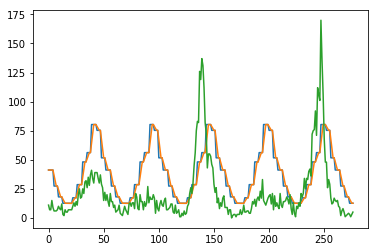

validation MAE: 24.636
monthly MAE: 25.515


In [38]:
# test a simnple linear model with a monthly mean
# instantiate the linear model
lr_sj = LinearRegression()
# get dummies for the month and year
X = pd.get_dummies(sj_train['month'], prefix='month')
y = sj_train_target.values

# fit the linear model
lr_sj.fit(X, y)

# Here we use the pandas rolling window function to create a mean trend w/i a spevified interval, 
# useful for time series data.
monthly_trend_train = pd.Series(lr_sj.predict(X)).rolling(3, min_periods = 1).mean()
sj_residuals_train = y - monthly_trend_train


# on validation data
# note: monthly trend does not need previous weeks data, so this can use the validation set
Xtest = pd.get_dummies(sj_valid['month'], prefix='month')
ytest = sj_valid_target.values
monthly_trend_valid = pd.Series(lr_sj.predict(Xtest)).rolling(3, min_periods=1).mean()
sj_residuals_test = ytest - monthly_trend_valid

# plot
plt.plot(lr_sj.predict(Xtest))
plt.plot(monthly_trend_valid)
plt.plot(ytest)
plt.show()

print('validation MAE:', round(mean_absolute_error(lr_sj.predict(Xtest), ytest),3))
print('monthly MAE:', round(mean_absolute_error(monthly_trend_valid, ytest),3))

As can be observed we are getting decent results with little modification. The goal for further tuning this model would be to adjust the time window functions to increase the degree of fit. Also, creating a more complex version of this type of time series analysis using ARIMAX or similar tends to work very well for this kind of task. 

Also, given the MAE's above there does not seem to ve too be any ocerfitting at this point, but that will certainly be something to watch for in future iterations on this proble as I increase the model complexity.

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


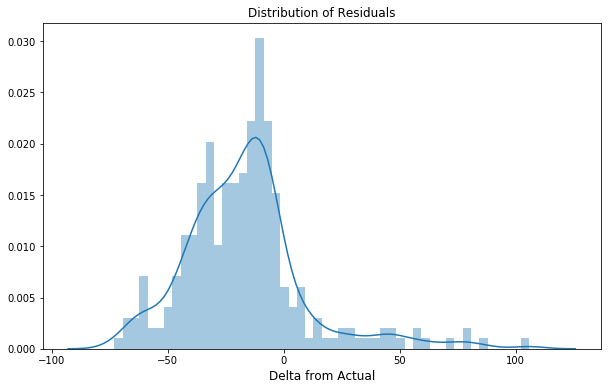

In [39]:
# plot the residuals of the model
plt.figure(figsize=(10,6))
sns.distplot(sj_residuals_test, bins = 50)
plt.xlabel('Delta from Actual', fontsize=12)
plt.title('Distribution of Residuals', fontsize = 12);

### Iquitos

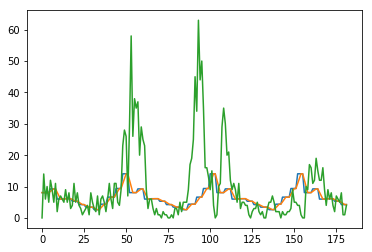

validation MAE: 6.382
monthly MAE: 6.412


In [40]:
# test a simnple linear model with a monthly mean

lr_iq = LinearRegression()
X = pd.get_dummies(iq_train['month'], prefix='month')
y = iq_train_target.values

lr_iq.fit(X, y)
monthly_trend_train = pd.Series(lr_iq.predict(X)).rolling(3, min_periods = 1).mean()
iq_residuals_train = y - monthly_trend_train


# on validation data
# note: monthly trend does not need previous weeks data, so this can use the validation set
Xtest = pd.get_dummies(iq_valid['month'], prefix='month')
ytest = iq_valid_target.values
monthly_trend_valid = pd.Series(lr_iq.predict(Xtest)).rolling(3, min_periods=1).mean()
iq_residuals_test = ytest - monthly_trend_valid

# plot
plt.plot(lr_iq.predict(Xtest))
plt.plot(monthly_trend_valid)
plt.plot(ytest)
plt.show()

print('validation MAE:', round(mean_absolute_error(lr_iq.predict(Xtest), ytest),3))
print('monthly MAE:', round(mean_absolute_error(monthly_trend_valid, ytest),3))

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


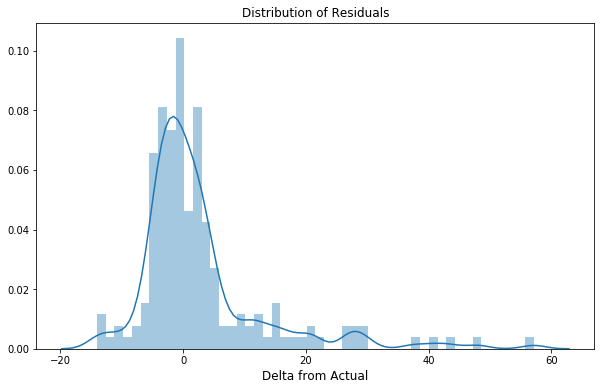

In [41]:
# plot the residuals of the model
plt.figure(figsize=(10,6))
sns.distplot(iq_residuals_test, bins = 50)
plt.xlabel('Delta from Actual', fontsize=12)
plt.title('Distribution of Residuals', fontsize = 12);

### Test Data

In [42]:
# Perform the same operations on the test data was for the training data
test = pd.read_csv('data/dengue_features_test.csv', parse_dates=[3])

sj_test = test[test['city'] == 'sj']
sj_test.drop('city', axis=1, inplace=True)
sj_test.drop('year', axis=1, inplace=True)

sj_test = sj_test.fillna(method = 'ffill')

sj_test['ndvi_mean'] = (sj_test['ndvi_ne'] + sj_test['ndvi_nw'] + sj_test['ndvi_se'] + sj_test['ndvi_sw']) / 4.0

ss = StandardScaler()
Xs = ss.fit_transform(sj_test[sj_test.columns[2:23]])
sj_test_s = pd.DataFrame(Xs, columns = sj_test.columns[2:23], index=sj_test.index)
sj_test_s['week_start_date'] = sj_test['week_start_date']
sj_test_s['weekofyear'] = sj_test['weekofyear']
sj_test_s['month'] = sj_test_s.week_start_date.dt.month
sj_test_s['year'] = sj_test_s.week_start_date.dt.year
sj_test_s.drop('week_start_date', axis=1, inplace=True)


iq_test = test[test['city'] == 'iq']
iq_test.drop('city', axis=1, inplace=True)
iq_test.drop('year', axis=1, inplace=True)

iq_test = iq_test.fillna(method = 'ffill')

iq_test['ndvi_mean'] = (iq_test['ndvi_ne'] + iq_test['ndvi_nw'] + iq_test['ndvi_se'] + iq_test['ndvi_sw']) / 4.0

ss = StandardScaler()
Xs = ss.fit_transform(iq_test[iq_test.columns[2:23]])
iq_test_s = pd.DataFrame(Xs, columns = iq_test.columns[2:23], index=iq_test.index)
iq_test_s['week_start_date'] = iq_test['week_start_date']
iq_test_s['month'] = iq_test_s.week_start_date.dt.month
iq_test_s['year'] = iq_test_s.week_start_date.dt.year
iq_test_s.drop('week_start_date', axis=1, inplace=True)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [43]:
# combine the predictions from both models for the test data
sj_submit = lr_sj.predict(pd.get_dummies(sj_test_s['month'], prefix='month'))
sj_submit = sj_submit.astype(int)
iq_submit = lr_iq.predict(pd.get_dummies(iq_test_s['month'], prefix='month'))
iq_submit = iq_submit.astype(int)
predictions = np.concatenate((sj_submit, iq_submit))

In [44]:
sj_submit

array([12, 12, 12, 12, 12, 17, 17, 17, 17, 28, 28, 28, 28, 28, 48, 48, 48,
       48, 56, 56, 56, 56, 56, 80, 80, 80, 80, 75, 75, 75, 75, 51, 51, 51,
       51, 41, 41, 41, 41, 41, 27, 27, 27, 27, 18, 18, 18, 18, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 17, 17, 17, 17, 28, 28, 28, 28, 28, 48, 48,
       48, 48, 56, 56, 56, 56, 80, 80, 80, 80, 80, 75, 75, 75, 75, 51, 51,
       51, 51, 41, 41, 41, 41, 41, 27, 27, 27, 27, 18, 18, 18, 18, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 17, 17, 17, 17, 28, 28, 28, 28, 28, 48,
       48, 48, 48, 56, 56, 56, 56, 80, 80, 80, 80, 80, 75, 75, 75, 75, 51,
       51, 51, 51, 41, 41, 41, 41, 41, 27, 27, 27, 27, 18, 18, 18, 18, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 17, 17, 17, 17, 28, 28, 28, 28, 28,
       48, 48, 48, 48, 56, 56, 56, 56, 80, 80, 80, 80, 80, 75, 75, 75, 75,
       51, 51, 51, 51, 41, 41, 41, 41, 41, 27, 27, 27, 27, 18, 18, 18, 18,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 17, 17, 17, 17, 28, 28, 28, 28,
       28, 48, 48, 48, 48

In [45]:
print(sj_submit.shape)
print(iq_submit.shape)
print(sj_submit.shape[0] + iq_submit.shape[0])
print(predictions.shape[0])
print(test.shape[0])

(260,)
(156,)
416
416
416


In [46]:
# combine predictions and export submission to csv
submission = pd.DataFrame(predictions, columns=["total_cases"])
submission.insert(0, 'city', test.city)
submission.insert(1, 'year', test.year)
submission.insert(2, 'weekofyear', test.weekofyear)
submission.reset_index()
submission.to_csv('data/Submission.csv', index = False)

 Competition MAE of ~26